# Echosounder Data Processing Example

This notebook will demonstrate the basic steps to load and plot the data from the so-called "zooplankton sonar" (ZPLS) on the OOI network. However, the sonar can not only see zooplankton, but also fish. On the OOI website, they are also called "Bio-acoustic Sonar." Here we are going to call it **echosounder**, which is how this type of sonar is usually called in fisheries and marine ecological studies.

## Echosounders on the OOI network

To figure out what echosounders are available on the OOI network, let's first get to http://oceanobservatories.org/instrument-class/zpls/ for an overview:
<img src="../img/zpls_table.png", width=650>

We can see that there are two types of echosounders: Modified EK60 from Kongsberg and AZFP from ASL Environmental Sciences. There are only 2 EK60's on the OOI network, located on the Cabled Endurance nodes (I am not sure if this is the right name... but we'll use it anyway). All other uncabled nodes have the AZFP echosounders.

Just to put things more into perspective, below you can see where the cabled and uncabled nodes are in the Endurance Array.
<img src="../img/endurance_echosounder.png", width=300>
In this demo we will use data from the EK-60 on the 200m platform at the Endurance Offshore Site (EAO, or Oregon Offshore Cabled Shallow Profiler Mooring). It is the red blob on the left in the map. You can find out more about this platform at http://oceanobservatories.org/site/ce04osps/

## Unpacking EK60 data

The first thing we need to do to process data from the echosounders is to unpack the data... from binary to something more accessible, such as HDF5. To do this, I created some tools that can be imported as modules from the local directory.

In [1]:
import glob, h5py, os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.dates import date2num
import sys
sys.path.insert(0,'../')
from unpack_ek60 import raw2hdf5_initiate, raw2hdf5_concat
import echopype_model

/Users/wu-jung/miniconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## Can the echosounders tell me how animals respond to eclipse?

Let's now try to unpack the echosounder data collected on August 21, 2017.

Does this sound like an important day? Maybe? :)

That was the day with all the hypes last year - when the eclipse happened and people across the US got to see it. In fact, the EAO site was right in the totality zone, so by looking at the echosounder data we will be able to see how the animals respond to the unusual change of solar radiation level, which we also have data for thanks to the OOI infrastructure!

So, how do the animals respond to eclipse? To answer this question, we need not only echosounder data, but also solar radiation data. In this demo we will do both and plot them together!

In [39]:
files = glob.glob('../OOI_data/OOI-D2017082[1,2]*.raw')
h5_fname = 'EAO-D20170821-22.h5'

In [6]:
raw2hdf5_initiate(files[0],h5_fname) # unpack 1st file and create HDF5 file
for fname in files[1:]:
    raw2hdf5_concat(fname,h5_fname)  # unpack other files and append to HDF5

00:58:36  unpacking file: ../OOI-D20170821-T000000.raw
00:58:39  unpacking file: ../OOI-D20170821-T013914.raw
00:58:43  unpacking file: ../OOI-D20170821-T031816.raw
00:58:46  unpacking file: ../OOI-D20170821-T045717.raw
00:58:50  unpacking file: ../OOI-D20170821-T063618.raw
00:58:53  unpacking file: ../OOI-D20170821-T081522.raw
00:58:58  unpacking file: ../OOI-D20170821-T095435.raw
00:59:02  unpacking file: ../OOI-D20170821-T113343.raw
00:59:05  unpacking file: ../OOI-D20170821-T131245.raw
00:59:10  unpacking file: ../OOI-D20170821-T145147.raw
00:59:15  unpacking file: ../OOI-D20170821-T163049.raw
00:59:18  unpacking file: ../OOI-D20170821-T180952.raw
00:59:22  unpacking file: ../OOI-D20170821-T194853.raw
00:59:26  unpacking file: ../OOI-D20170821-T212802.raw
00:59:29  unpacking file: ../OOI-D20170821-T230706.raw
00:59:31  unpacking file: ../OOI-D20170822-T000000.raw
00:59:34  unpacking file: ../OOI-D20170822-T013902.raw
00:59:37  unpacking file: ../OOI-D20170822-T031804.raw
00:59:41  

Now we have the echosounder data stored as HDF5 for easy access.

The above can also be done through command line by calling `echopype_converter.py`. The usage is:

```
$ python echopype_converter.py -h
Convert EK60 *.raw to HDF5

optional arguments:
  -h, --help            show this help message and exit
  -o OUTPUT_FILE, --output-file OUTPUT_FILE
                        output HDF5 filename
  -i INPUT_FILE [INPUT_FILE ...], --input-file INPUT_FILE [INPUT_FILE ...]
                        input *.raw filename
```

## Cleaning and subsetting raw echo data

The next step is to clean up the raw data we just loaded and do some basic compensation of the transmission loss of sound due to propagation and absorption by seawater. The operations will be done by using methods from a python class `EchoDataRaw`. We will first create an instance of this class with the HDF5 file we just created.

In [38]:
# create EchoDataRaw object for manipulation
edata = echopype_model.EchoDataRaw(h5_fname)
edata_clean = echopype_model.EchoDataRaw(h5_fname)

### Case 1: Noise removal

The first thing is estimate how much noise there is from either backgound or instruments, or both. There are a few _standard_ (as in convention of the field) ways to do it. I implemented the method proposed by De Robertis and Higginbottom (2007, ICES JMR) to do this.

This is a fairly expensive operation and I want to see if this can be sped up by by distributed processing.

In [ ]:
%%time
edata_clean.remove_noise()  # regular noise removal

### Subsetting echo data

Now, the echosounder transmits sound every second for the whole day. It seems a bit unnecessary to try to plot out every single ping, since at the scale we are looking at (i.e., a day), things to the most part don't change that fast. Therefore, we can subset the data so that we only use 1 ping of data every 2 mins.

Note that I put in kwarg `hr_offset=7` because the observation was done in PDT, but the instrument was configured using UTC time.

In [5]:
%%time
import datetime as dt
date_wanted = [dt.date(2017,8,21).strftime('%Y%m%d')]
subset_params_names = ["hour_all","min_all","sec_all"]
subset_params_vals = (range(24),range(0,54,2),[0])
subset_params = dict(zip(subset_params_names,subset_params_vals))
edata_clean.subset_data(date_wanted,subset_params,hr_offset=7)   # subset data

CPU times: user 11.3 s, sys: 15.4 s, total: 26.7 s
Wall time: 53.9 s


Let's take a look at how the echogram looks like:

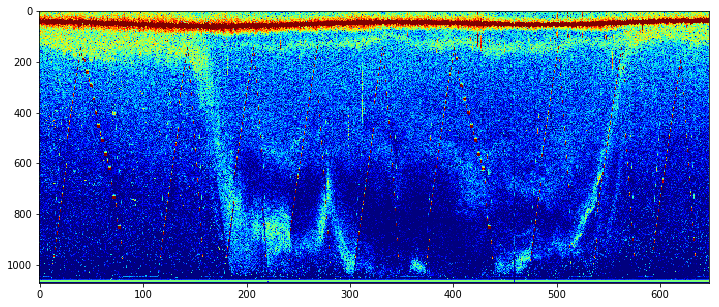

In [21]:
fig = plt.figure(figsize=(12,5))
plt.imshow(edata.Sv_corrected['200000.0'][::-1,:],aspect='auto',vmax=-30,vmin=-80,cmap='jet')
plt.show()

As you see, there is a lot of empty spots in the middle, and it's difficult to get a clear picture of what's going on. Normally when echo data are used to estimate biomass of marine organisms, these cleaned data will be further averaged into each small tiles to obtain the mean volume backscattering strength (MVBS). But let's not worry about that operation right now and just use all the data points.

### Case 2: No noise removal

In this second case, we will not remove any noise from the data:

In [4]:
%%time
const_noise = 0
edata.remove_noise(const_noise)  # put in a dummy constant noise level

../echopype_model.py:186: RuntimeWarning: divide by zero encountered in log10
  Sv_noise[freq_str] = 10*np.log10(self.noise_est[freq_str])+TVG+ABS-CSv-Sac


CPU times: user 1min 7s, sys: 1min 37s, total: 2min 44s
Wall time: 4min 2s


In [ ]:
edata.subset_data(date_wanted,subset_params,hr_offset=7)   # subset data

Note that in Case 2 above, I put in a constant noise level (=0). This is just a dummy, because here I want to see how the data look like without taking out any points (i.e., treating everything as "data"). What's really important in `remove_noise` is that the transmission loss of sound is compensated for, even if I only put in a dummy for the noise level. If I call this method as: `edata.remove_noise()` without the dummy, the code will call `edata.get_noise()` to estimate the noise level, remove any data points that are below the estimated noise level, and compensate for the transmission loss.

Again let's take a look at how the echogram looks like:

In [ ]:
fig = plt.figure(figsize=(12,5))
plt.imshow(edata.Sv_corrected['200000.0'][::-1,:],aspect='auto',vmax=-30,vmin=-80,cmap='jet')
plt.show()

The picture beomces much clearer now that ours eyes are not distracted by the empty spots.

## Shortwave radiation

To answer the question of how animals respond to eclipse, we need not only echosounder data, but also solar radiation data. Luckily from the National Data Buoy Center (http://www.ndbc.noaa.gov/) we can see that there is a surface buoy with a pyranometer that measures shortwave radiation (SRAD1 on the NDBC website) at the EAO site (Station 46098: http://www.ndbc.noaa.gov/station_page.php?station=46098). I downloaded the data last year shortly after eclipse via Real Time Data --> Real time standard meteorological data. Here, real-time means in the last 45 days. After looking up on the data format, we can write a couple simple functions to read in the radiation level:

In [22]:
def read_srad(filefullpath):
    '''
    Read txt file downloaded from **reatlime solar radiation data**
    from http://www.ndbc.noaa.gov/station_page.php?station=46098
    '''
    f = open(filefullpath, 'rU')
    header1 = f.readline().split()
    header2 = f.readline().split()
    data_block = f.readlines()
    
    data = {}
    for col_name in header1:
        data[col_name] = np.ma.zeros(len(data_block), 'f',\
                                     fill_value = -999.999)
        
    for (line_count, line) in enumerate(data_block):
        items = line.split()    
        for (col_count, col_name) in enumerate(header1):
            value = items[col_count]
            if value == "MM":
                value = np.ma.masked
            else:
                value = float(value)
            data[col_name][line_count] = value
            
    f.close()
    return data

In [23]:
srad_data = read_srad('eao_buoy_solar_radiation_20170831download.txt')

/Users/wu-jung/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: 'U' mode is deprecated
  


Similar to what we have done with the echosounder data, we also want to subset the radiation data set here.

In [24]:
def subset_srad(data,YY,MM,DD,all_hr,all_min,hr_offset):
    # Get datetime object for all pings
    every_rec = [dt.datetime(YY,MM,DD,hr,minutes,0) \
                  for hr in all_hr for minutes in all_min]  # UTC time
    every_rec = [x+dt.timedelta(seconds=hr_offset*60*60) for x in every_rec]  # adjust to local time
    
    # Get timestamp for all radiation records
    rec_time = [dt.datetime(y,m,d,h,mmin,0) for (y,m,d,h,mmin) in \
                zip(data['#YY'],data['MM'],data['DD'],data['hh'],data['mm'])]
    rec_time_num = date2num(rec_time)
    
    # Return index of solar radiation time series
    return [np.argmin(np.abs(rec_time_num-date2num(x))) for x in every_rec]

We know that radiation measurements came in every 10 mins, so we subset the data as below. Note that we have `hr_offset=7` as well, because the observation was done in PDT, but the instrument was configured using UTC time.

In [28]:
all_minutes_rec = range(0,60,10)  # radiation data came every 10 mins
idx_subset = subset_srad(srad_data,2017,8,21,subset_params['hour_all'],all_minutes_rec,7)

In [29]:
# rec_per_day = len(all_hr)*len(all_minutes_rec)
rec_per_hr = len(all_minutes_rec)
rec_idx = range(0,24*rec_per_hr,rec_per_hr)       # for solar radiation
rec_labels = [str(x) for x in range(24)]

/Users/wu-jung/miniconda3/lib/python3.6/site-packages/matplotlib/axes/_base.py:3291: UserWarning: Attempted to set non-positive ylimits for log-scale axis; invalid limits will be ignored.
  'Attempted to set non-positive ylimits for log-scale axis; '


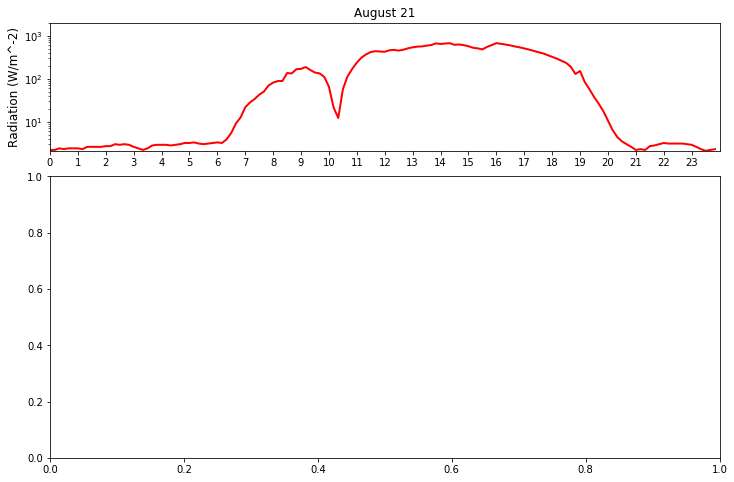

In [36]:
plt.figure(figsize=(12,8))
ax0 = plt.subplot2grid((3, 1), (0, 0))
ax1 = plt.subplot2grid((3, 1), (1, 0),rowspan=2)

ax0.plot(srad_data['SRAD1'][idx_subset],'r',linewidth=2)
ax0.set_yscale('log')
ax0.set_xticks(rec_idx)
ax0.set_xticklabels(rec_labels)
ax0.set_xlim([0,24*rec_per_hr])
ax0.set_ylim([0,2E3])
ax0.set_yscale('log')
ax0.set_ylabel('Radiation (W/m^-2)',fontsize=12)
ax0.set_title('August 21')

plt.show()
